<a href="https://colab.research.google.com/github/IAmirKhani/Automatic-Sleep-Scoring/blob/main/featureMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fooof

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install neurodsp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.1 MB/s eta 0:00:00


In [ ]:
# NeuroDSP
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
# FOOOF
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
# Other
from scipy.io import loadmat
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

<ipython-input-3-edf5e8b543a1>:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path_to_pt5 = '/content/drive/My Drive/Donders/Automated Sleep Scoring'

In [ ]:
hpc_data = loadmat(path_to_pt5 + '/HPC_100_CH31.continuous.mat')
hpc_data = hpc_data['HPC']
hpc_data = hpc_data[8*1000:]

In [ ]:
pfc_data = loadmat(path_to_pt5 + '/PFC_100_CH49.continuous.mat')
pfc_data = pfc_data['PFC']
pfc_data = pfc_data[8*1000:]

In [ ]:
sleep_scoring = loadmat(path_to_pt5 + '/post_trial5_2017-11-15_14-04-39-states.mat')
sleep_scoring = sleep_scoring['states']
sleep_scoring = sleep_scoring[0, 7:]

In [ ]:
print(hpc_data.shape)
print(len(hpc_data) // 1000)
print(len(pfc_data) // 1000)
print(len(sleep_scoring))

(10535053, 1)
10535
10535
10535


In [ ]:
hpc_data.shape

(10535053, 1)

In [ ]:
import numpy as np
from scipy.stats import zscore
from scipy.interpolate import interp1d

def find_intervals(signal, threshold):
    above_threshold = np.where(signal > threshold)[0]
    if not above_threshold.size:
        return np.zeros((0, 2), dtype=int)

    intervals = np.split(above_threshold, np.where(np.diff(above_threshold) != 1)[0] + 1)
    intervals = np.array([[interval[0], interval[-1]] for interval in intervals])
    return intervals

def consolidate_intervals(intervals, around_artifact):
    if not intervals.size:
        return intervals

    intervals[:, 0] -= around_artifact
    intervals[:, 1] += around_artifact
    intervals = intervals[intervals[:, 0].argsort()]

    consolidated = [intervals[0]]
    for interval in intervals:
        if interval[0] <= consolidated[-1][1]:
            consolidated[-1][1] = max(consolidated[-1][1], interval[1])
        else:
            consolidated.append(interval)
    return np.array(consolidated)

def in_intervals(time_values, intervals):
    inds = np.zeros_like(time_values, dtype=bool)
    for start, end in intervals:
        inds |= (time_values >= start) & (time_values <= end)
    return inds

def remove_artifacts(lfp_sig, amp_thresh, time_win_thresh):
    time_values = np.arange(len(lfp_sig))

    z_sig = zscore(lfp_sig[:, 0])
    diff_sig = np.append(np.diff(z_sig), 0)

    artifact_interval = find_intervals(np.abs(z_sig), amp_thresh[0])
    artifact_interval = consolidate_intervals(artifact_interval, time_win_thresh[0])
    artifact_inds = in_intervals(time_values, artifact_interval)

    noisy_interval = find_intervals(np.abs(diff_sig), amp_thresh[1])
    noisy_interval = consolidate_intervals(noisy_interval, time_win_thresh[1])
    artifact_inds |= in_intervals(time_values, noisy_interval)

    sig_values = lfp_sig.copy()

    if np.any(artifact_inds) and np.any(~artifact_inds):
        interp_func = interp1d(time_values[~artifact_inds], sig_values[~artifact_inds, 0], kind='linear', fill_value='extrapolate')
        sig_values[artifact_inds, 0] = interp_func(time_values[artifact_inds])
    elif np.all(artifact_inds):
        sig_values[:] = np.nan

    return sig_values, artifact_inds

In [ ]:
amp_thresh = [3, 1]
time_win_thresh = [20*60, 1*60]

cleaned_data, artifacts = remove_artifacts(hpc_data, amp_thresh, time_win_thresh)

In [ ]:
cleaned_data_pfc, artifacts = remove_artifacts(pfc_data, amp_thresh, time_win_thresh)

In [ ]:
sig_hpc = cleaned_data
sig_pfc = cleaned_data_pfc

In [ ]:
hpc_normalized_nclean = zscore(hpc_data)
pfc_normalized_nclean = zscore(pfc_data)

In [ ]:
sig_hpc_nclean = np.ravel(hpc_normalized_nclean)
sig_pfc_nclean = np.ravel(pfc_normalized_nclean)

# Analyzing the full 3 hours of the data

# Delta Power

In [ ]:
hpc_normalized = zscore(sig_hpc)
pfc_normalized = zscore(sig_pfc)

In [ ]:
sig_hpc = np.ravel(hpc_normalized)
sig_pfc = np.ravel(pfc_normalized)
fs = 1000

In [ ]:
def extract_peak_power(lfp_data, fs, beta_band):
    all_power_sum = []
    window_length = 3 * fs

    # loop through each segment and fit FOOOF
    for start in range(0, len(lfp_data) - window_length + 1, window_length):
        window = lfp_data[start:min(start + window_length, len(lfp_data))]
        freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)

        # initialize FOOOF and fit the spectrum data
        fm = FOOOF()
        fm.fit(freq_mean, psd_mean, beta_band)

        curr_sum = 0

        freq_indices = (freq_mean >= beta_band[0]) & (freq_mean <= beta_band[1])

        for peak in fm.peak_params_:
            center_freq, peak_power, bandwidth = peak
            start_freq = center_freq - bandwidth / 2
            end_freq = center_freq + bandwidth / 2
            indices = freq_indices & (freq_mean >= start_freq) & (freq_mean <= end_freq)
            curr_sum += np.sum(psd_mean[indices])

        all_power_sum.append(curr_sum)

    return all_power_sum

In [ ]:
delta_band = [1, 4]
delta_power = extract_peak_power(sig_pfc, fs, delta_band)

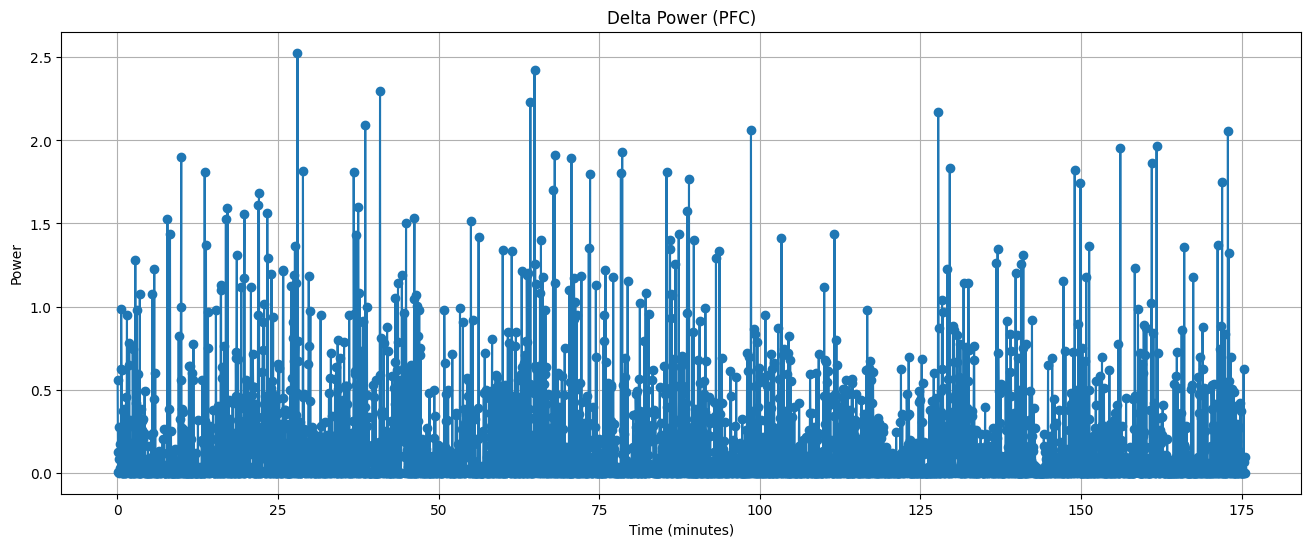

In [ ]:
time = np.arange(1.5, 1.5 + 3 * len(delta_power), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, delta_power, marker='o', linestyle='-')
plt.title("Delta Power (PFC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Power")
plt.grid(True)
plt.show()

In [ ]:
def NormalizeData(data):
      return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
normalized_delta_power = zscore(delta_power)

In [ ]:
epsilon_value = 1e-3

# replace zeros with epsilon
normalized_delta_power = np.where(normalized_delta_power == 0, epsilon_value, normalized_delta_power)

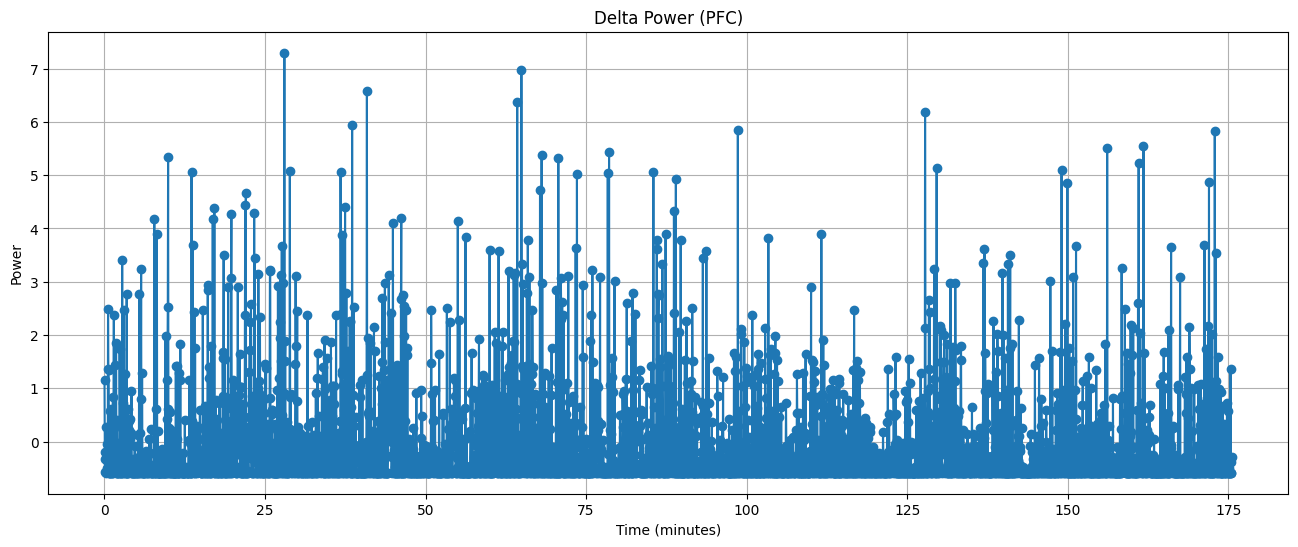

In [ ]:
time = np.arange(1.5, 1.5 + 3 * len(normalized_delta_power), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, normalized_delta_power, marker='o', linestyle='-')
plt.title("Delta Power (PFC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Power")
plt.grid(True)
plt.show()

In [ ]:
delta_power_alternate = extract_peak_power(data_PFC, fs, delta_band)

In [ ]:
def extract_peak_power(lfp_data, fs, beta_band, freq_range):
    peak_power_sum = []
    window_length = 3 * fs

    # loop through each segment and fit FOOOF model
    for start in range(0, len(lfp_data) - window_length + 1, window_length):
        window = lfp_data[start:start + window_length]
        freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)

        # initialize FOOOF model and fit the spectrum data
        fm = FOOOF()
        fm.fit(freq_mean, psd_mean, freq_range)

        # sum the power of all peaks in the beta band
        power_sum = 0
        for peak in fm.peak_params_:
            center_freq, peak_power, bandwidth = peak
            if beta_band[0] <= center_freq <= beta_band[1]:
                start_freq = center_freq - bandwidth / 2
                end_freq = center_freq + bandwidth / 2

                # find the indices of the frequencies that fall within this range
                indices = np.where((freq_mean >= start_freq) & (freq_mean <= end_freq))

                # sum the power of these frequencies
                power_sum += np.sum(psd_mean[indices])

        peak_power_sum.append(power_sum)

    return peak_power_sum

In [ ]:
freq_range = [1, 60]
delta_power_alternate = extract_peak_power(data_PFC, fs, delta_band, freq_range)

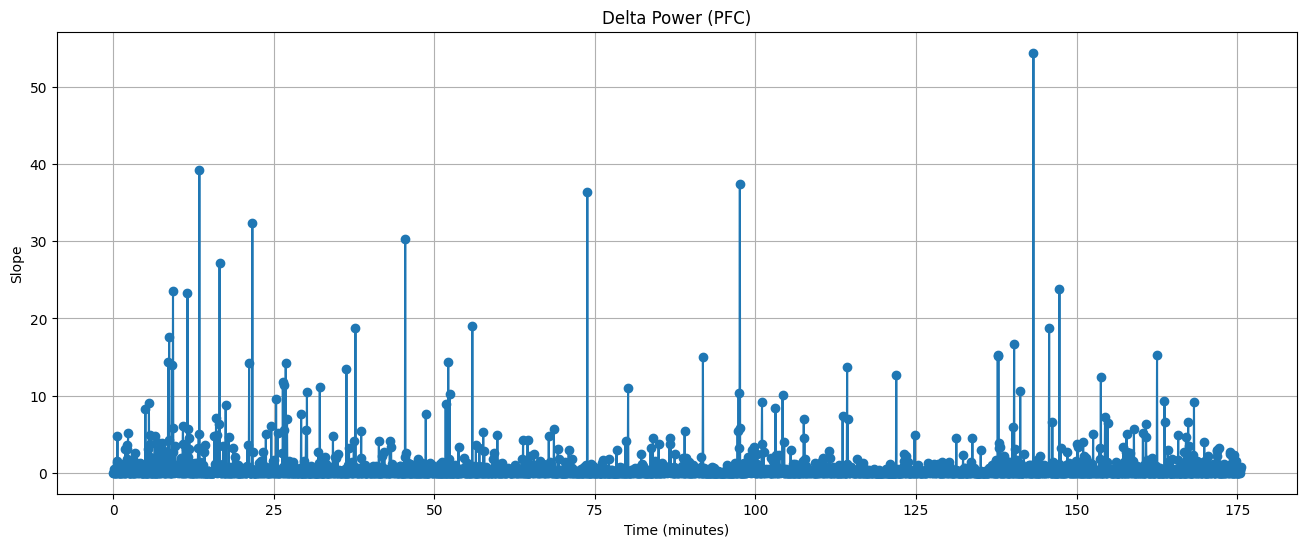

In [ ]:
time = np.arange(1.5, 1.5 + 3 * len(delta_power_alternate), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, delta_power_alternate, marker='o', linestyle='-')
plt.title("Delta Power (PFC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()

## A try

In [ ]:
def extract_peak_power(lfp_data, fs, freq_range, delta_band):
    all_power_sum = []
    window_length = 3 * fs

    # loop through each segment and fit FOOOF model
    for start in range(0, len(lfp_data) - window_length + 1, window_length):
        window = lfp_data[start:min(start + window_length, len(lfp_data))]
        freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)

        # initialize FOOOF model and fit the spectrum data
        fm = FOOOF()
        fm.fit(freq_mean, psd_mean, freq_range)

        curr_sum = 0

        freq_indices = (freq_mean >= delta_band[0]) & (freq_mean <= delta_band[1])

        for peak in fm.peak_params_:
            center_freq, peak_power, bandwidth = peak
            if delta_band[0] <= center_freq <= delta_band[1]:
              start_freq = center_freq - bandwidth / 2
              end_freq = center_freq + bandwidth / 2
              indices = freq_indices & (freq_mean >= start_freq) & (freq_mean <= end_freq)
              curr_sum += np.sum(psd_mean[indices])

        all_power_sum.append(curr_sum)

    return all_power_sum

# Theta Power

In [ ]:
theta_band = [5, 12]
theta_power = extract_peak_power(sig_hpc, fs, theta_band)

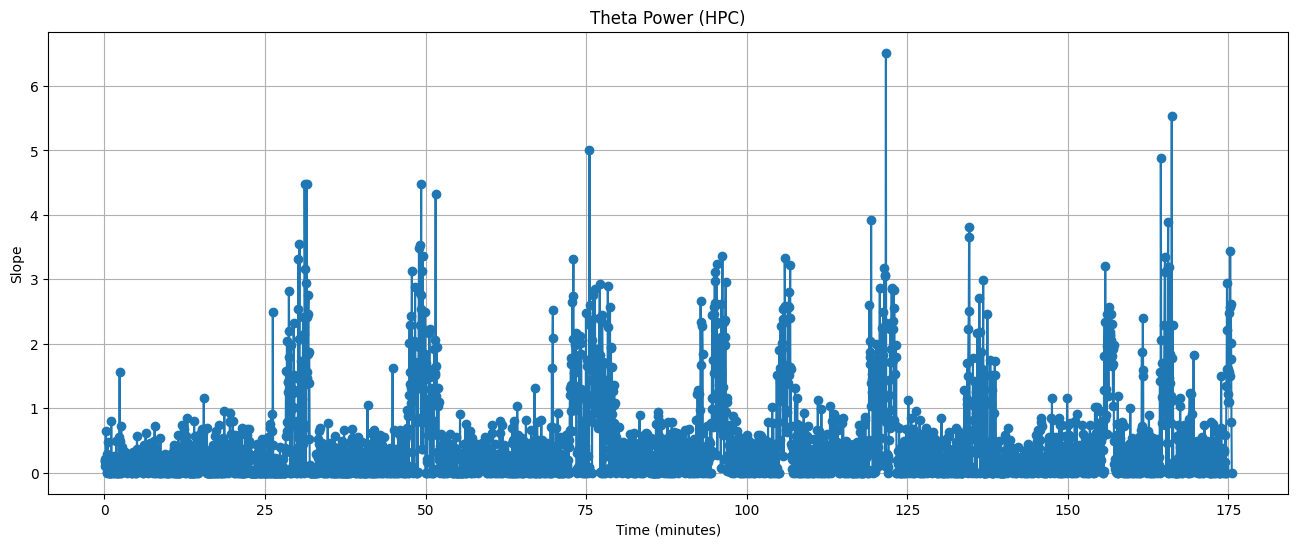

In [ ]:
time = np.arange(1.5, 1.5 + 3 * len(theta_power), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, theta_power, marker='o', linestyle='-')
plt.title("Theta Power (HPC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()

In [ ]:
normalized_theta_power = zscore(theta_power)

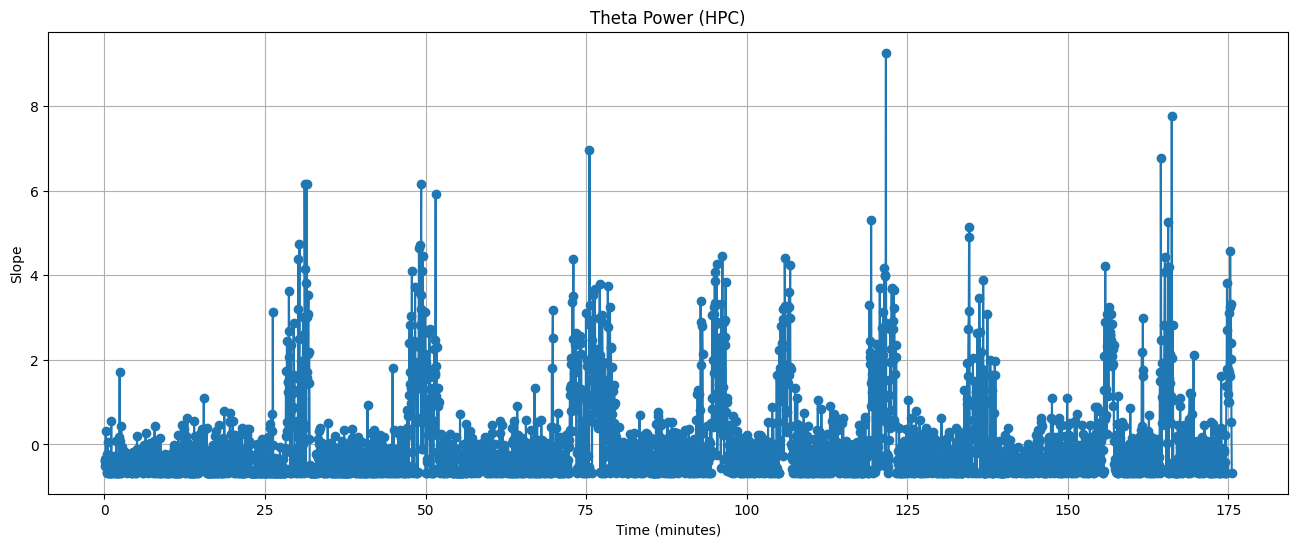

In [ ]:
time = np.arange(1.5, 1.5 + 3 * len(normalized_theta_power), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, normalized_theta_power, marker='o', linestyle='-')
plt.title("Theta Power (HPC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()

In [ ]:
delta_power_array = np.array(normalized_delta_power)
theta_power_array = np.array(normalized_theta_power)

ratio_array = theta_power_array / delta_power_array

In [ ]:
normalized_ratio = zscore(ratio_array)

## HPC

In [ ]:
# extracting the full 3 hours of HPC data and segmenting it into 3-second windows.w
window_length = 3 * fs
aperiodic_params_HPC = []
freq_range = [1, 100]
for start in range(0, len(sig_hpc_nclean) - window_length + 1, window_length):
    window = sig_hpc_nclean[start:start + window_length]
    window = np.ravel(window)
    freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)
    fm = FOOOF()
    fm.fit(freq_mean, psd_mean, freq_range)
    aperiodic_params_HPC.append(fm.get_params('aperiodic_params'))

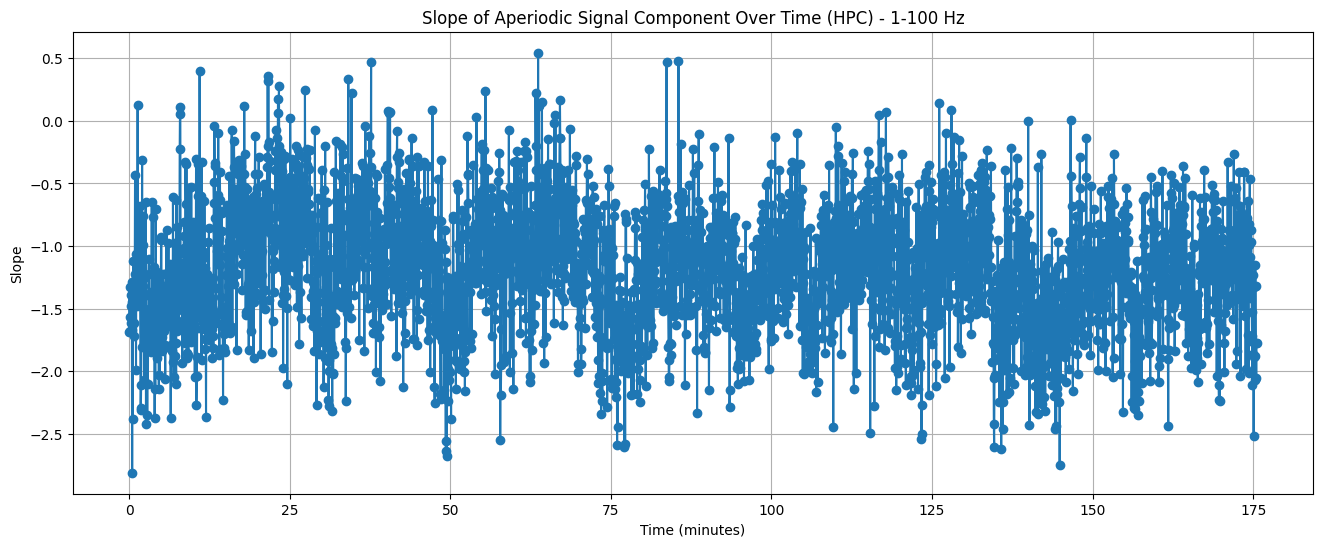

In [ ]:
# extracting slopes of Aperiodic Signal Component Over Time
slopes_HPC = [param[0] for param in aperiodic_params_HPC]
time = np.arange(1.5, 1.5 + 3 * len(aperiodic_params_HPC), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, slopes_HPC, marker='o', linestyle='-')
plt.title("Slope of Aperiodic Signal Component Over Time (HPC) - 1-100 Hz")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()

In [ ]:
# Normalizing and smoothing the data
slopes_normalized_HPC = zscore(slopes_HPC)
slopes_smoothed_HPC = savgol_filter(slopes_normalized_HPC, window_length=101, polyorder=4)

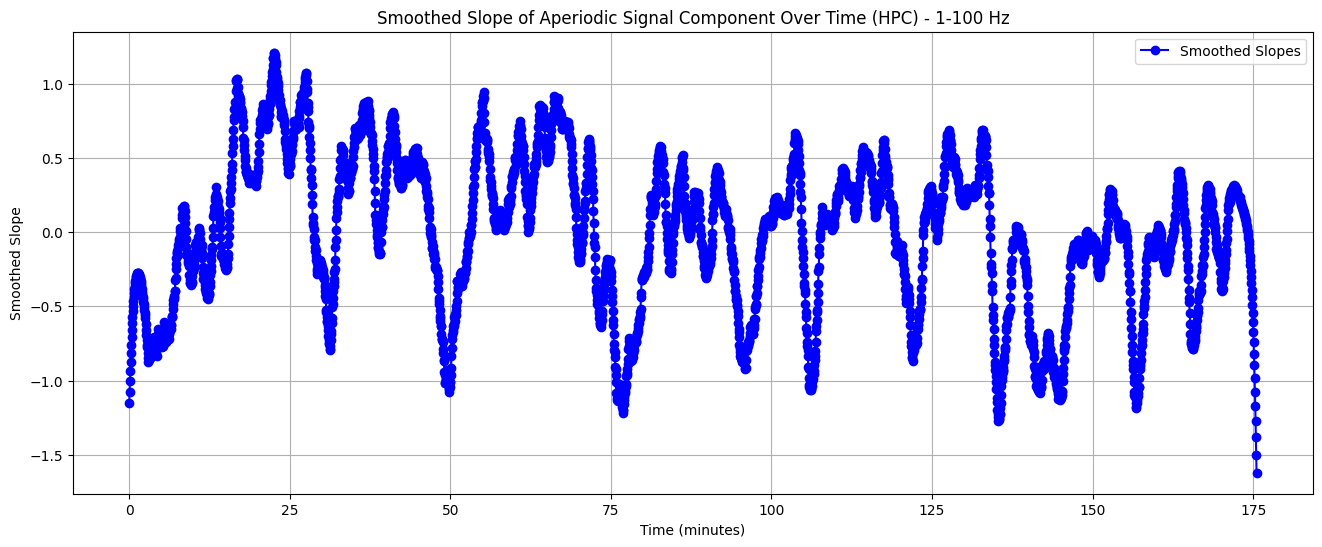

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time_minutes, slopes_smoothed_HPC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Slope of Aperiodic Signal Component Over Time (HPC) - 1-100 Hz")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Slope")
plt.grid(True)
plt.legend()
plt.show()

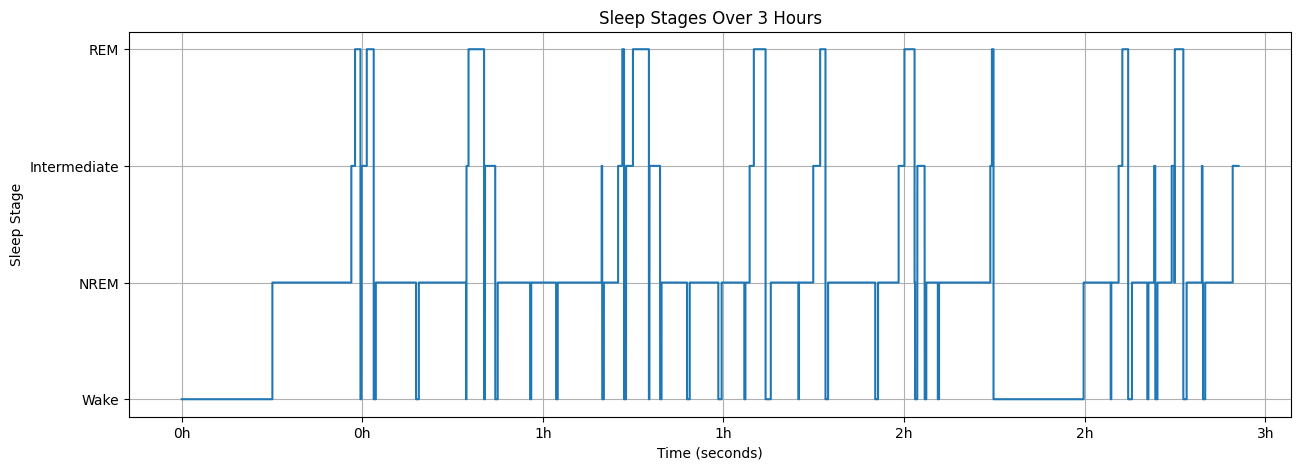

In [ ]:
score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
labeled_scores = [score_labels[score] for score in sleep_scoring]

time_seconds = np.arange(0, len(labeled_scores))  # Assuming one score per second

plt.figure(figsize=(15, 5))  # Wider plot for better visibility
plt.step(time_seconds, labeled_scores, where='mid')  # Using a step plot
plt.xlabel('Time (seconds)')
plt.ylabel('Sleep Stage')
plt.title('Sleep Stages Over 3 Hours')
plt.yticks(list(score_labels.values()))  # Set y-ticks to the stage labels
plt.xticks(np.arange(0, 10801, 1800), [f"{int(x/3600)}h" for x in np.arange(0, 10801, 1800)])  # Marking each half hour
plt.grid(True)
plt.show()

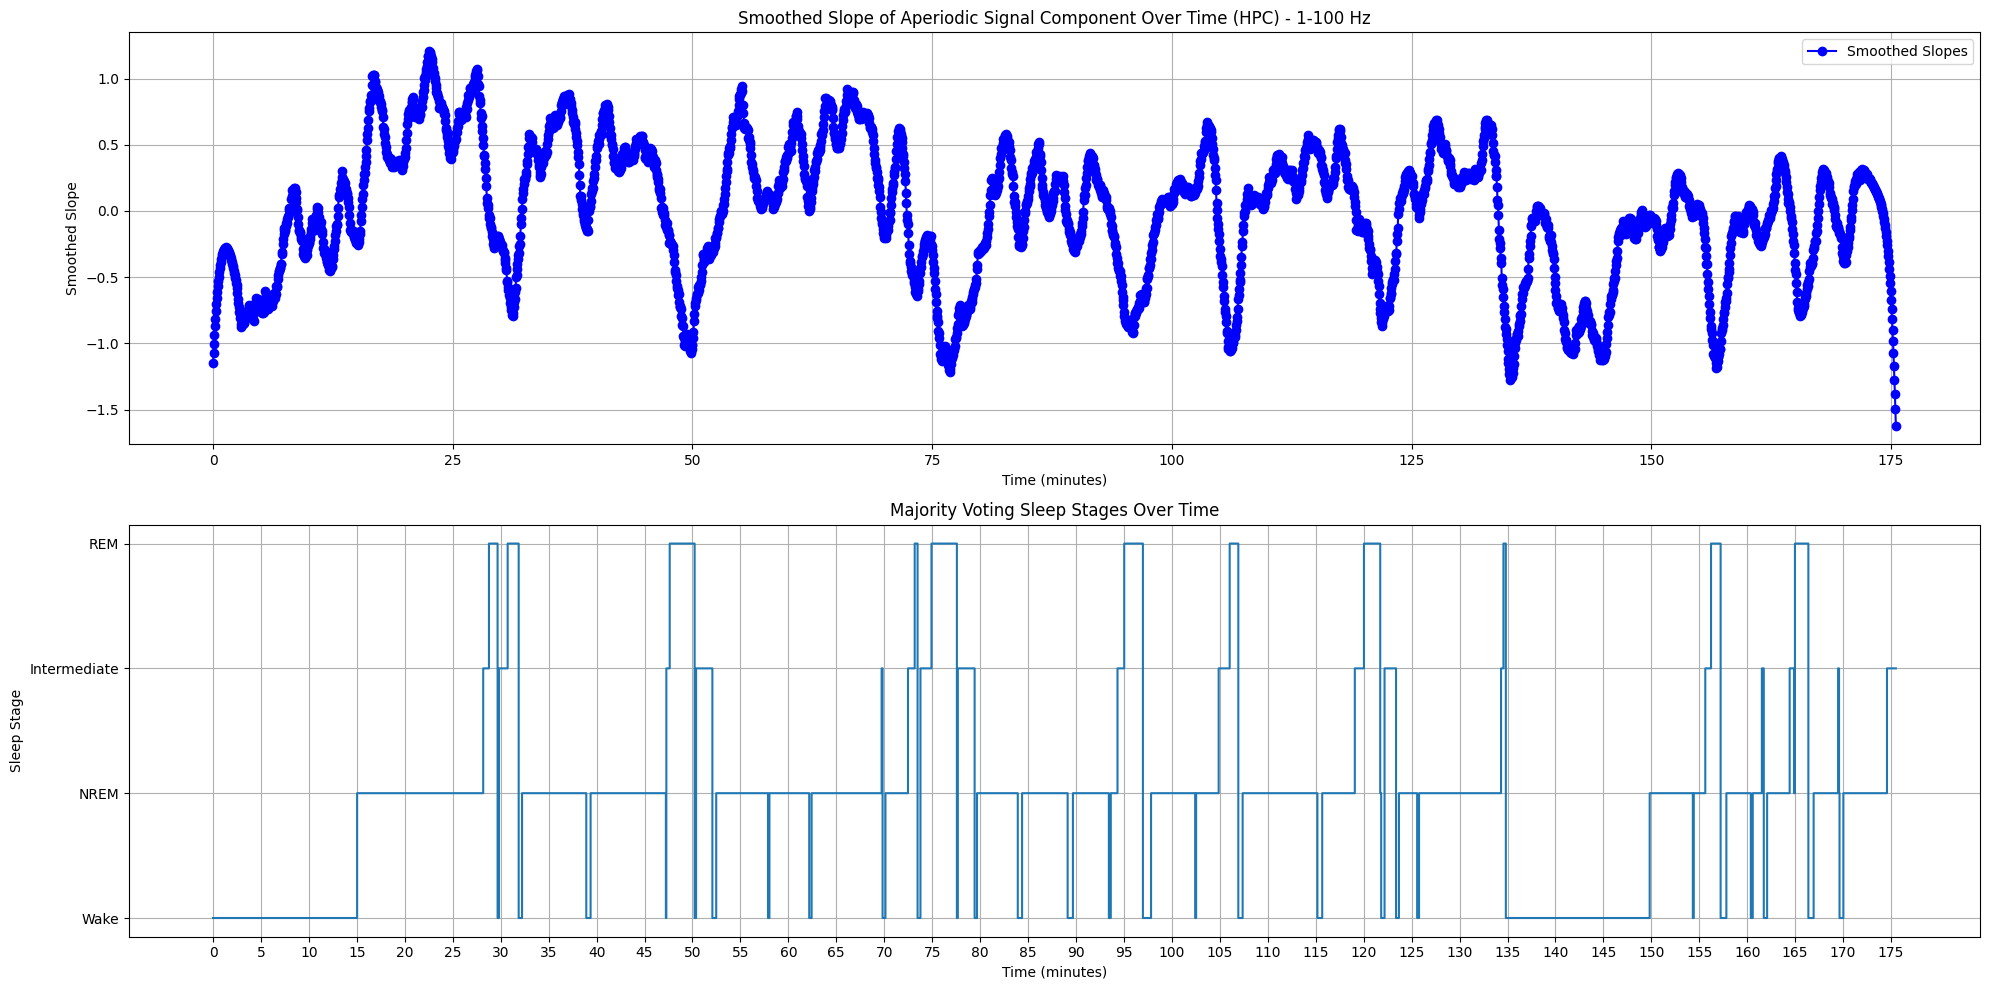

In [ ]:
score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}
sleep_scoring_ = sleep_scoring[:10533]
# majority voting
sleep_scoring_ = np.array(sleep_scoring_)
reshaped_scores = sleep_scoring_.reshape(-1, 3)
majority_scores = mode(reshaped_scores, axis=1).mode.flatten()

assert all(score in score_labels for score in majority_scores), "Some scores are not in score_labels"

mapped_scores = np.array([num_labels[score_labels[score]] for score in majority_scores])

time_minutes = np.arange(0, len(slopes_smoothed_HPC)) * 3 / 60
sleep_time_minutes = np.arange(0, len(majority_scores)) * 3 / 60
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(time_minutes, slopes_smoothed_HPC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Slope of Aperiodic Signal Component Over Time (HPC) - 1-100 Hz")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Slope")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.step(sleep_time_minutes, mapped_scores, where='mid')
plt.xlabel('Time (minutes)')
plt.ylabel('Sleep Stage')
plt.title('Majority Voting Sleep Stages Over Time')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xticks(np.arange(0, max(sleep_time_minutes) + 1, 5))
plt.grid(True)

plt.tight_layout()

plt.show()

In [ ]:
len(slopes_smoothed_HPC[1:])

3511

In [ ]:
slopes_smoothed_HPC = np.asarray(slopes_smoothed_HPC)

means_smoothed = []
stds_smoothed = []
means_unsmoothed = []
stds_unsmoothed = []

score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
for score, label in score_labels.items():

    relevant_indices = majority_scores == score

    slopes_smoothed_HPC = slopes_smoothed_HPC
    relevant_slopes_smoothed = slopes_smoothed_HPC[relevant_indices]
    means_smoothed.append(np.nanmean(relevant_slopes_smoothed))
    stds_smoothed.append(np.nanstd(relevant_slopes_smoothed))

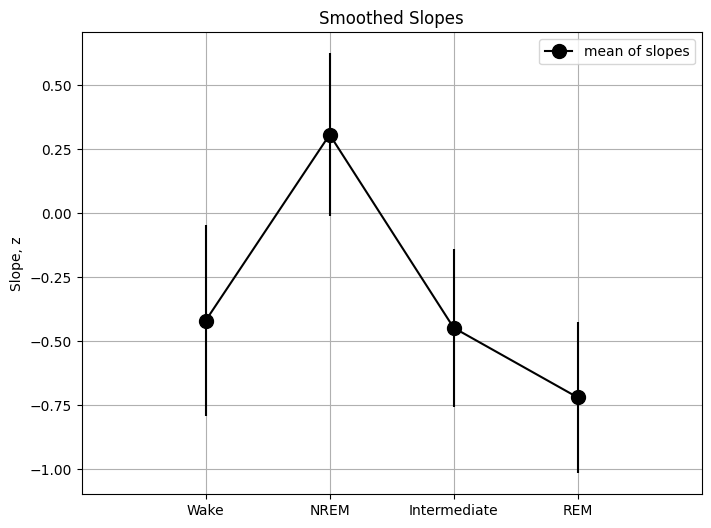

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(1, len(score_labels)+1), means_smoothed, yerr=stds_smoothed, fmt='-ok', markersize=10,
             markeredgecolor='black', markerfacecolor='black', label='mean of slopes')
plt.ylabel("Slope, z")
plt.title("Smoothed Slopes")
plt.grid(True)
plt.xticks(ticks=range(1, len(score_labels)+1), labels=score_labels.values())
plt.xlim(0, len(score_labels) + 1)
plt.legend()
plt.show()

# Theta powers


In [ ]:
from fooof import FOOOF

theta_band = [5, 12]
freq_range = [1, 60]

def extract_highest_theta_peak(lfp_data, fs, theta_band, freq_range):
    highest_theta_peak_params = []
    window_length = 3 * fs

    for start in range(0, len(lfp_data) - window_length + 1, window_length):
        window = lfp_data[start:start + window_length]
        freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)

        # initialize FOOOF model and fit the spectrum data
        fm = FOOOF()
        fm.fit(freq_mean, psd_mean, freq_range)

        # find the highest peak in the theta band
        highest_peak = None
        for peak in fm.peak_params_:
            center_freq, peak_power, bandwidth = peak
            if theta_band[0] <= center_freq <= theta_band[1]:
                if highest_peak is None or peak_power > highest_peak[1]:
                    highest_peak = (center_freq, peak_power, bandwidth)

        if highest_peak:
            highest_theta_peak_params.append(highest_peak[1])
        else:
            highest_theta_peak_params.append(np.mean(highest_theta_peak_params[-1] + highest_theta_peak_params[-2]))

    return highest_theta_peak_params

In [ ]:
highest_theta_peaks = extract_highest_theta_peak(data_HPC, fs, theta_band, freq_range)

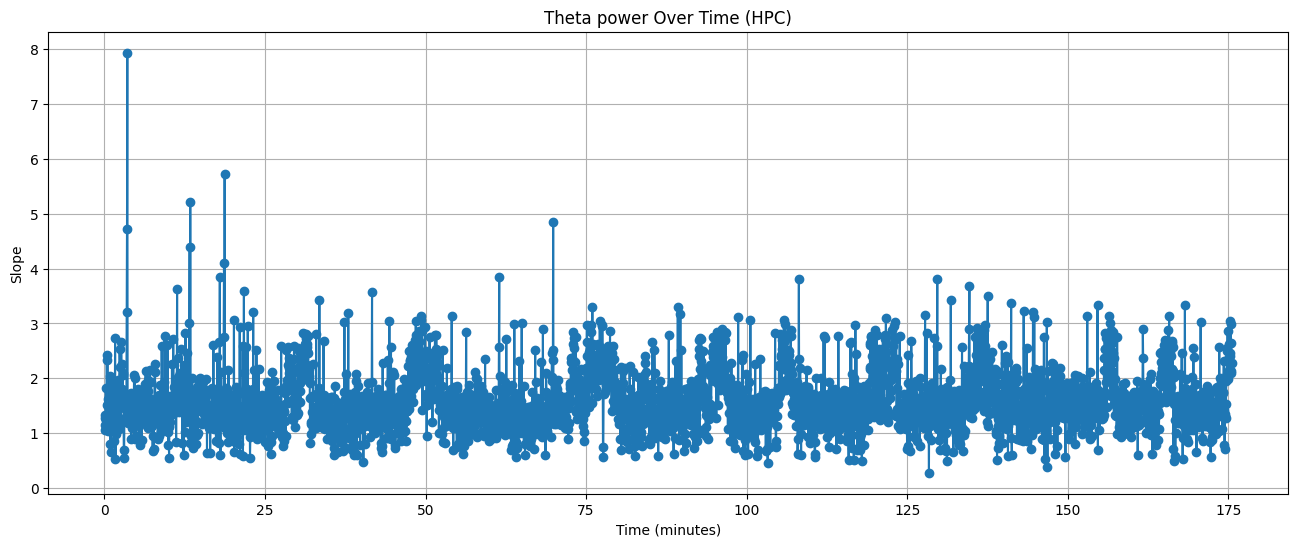

In [ ]:
time = np.arange(1.5, 1.5 + 3 * len(highest_theta_peaks), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, highest_theta_peaks, marker='o', linestyle='-')
plt.title("Theta power Over Time (HPC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()

In [ ]:
theta_peak_smoothed_HPC = savgol_filter(highest_theta_peaks, window_length=101, polyorder=4)

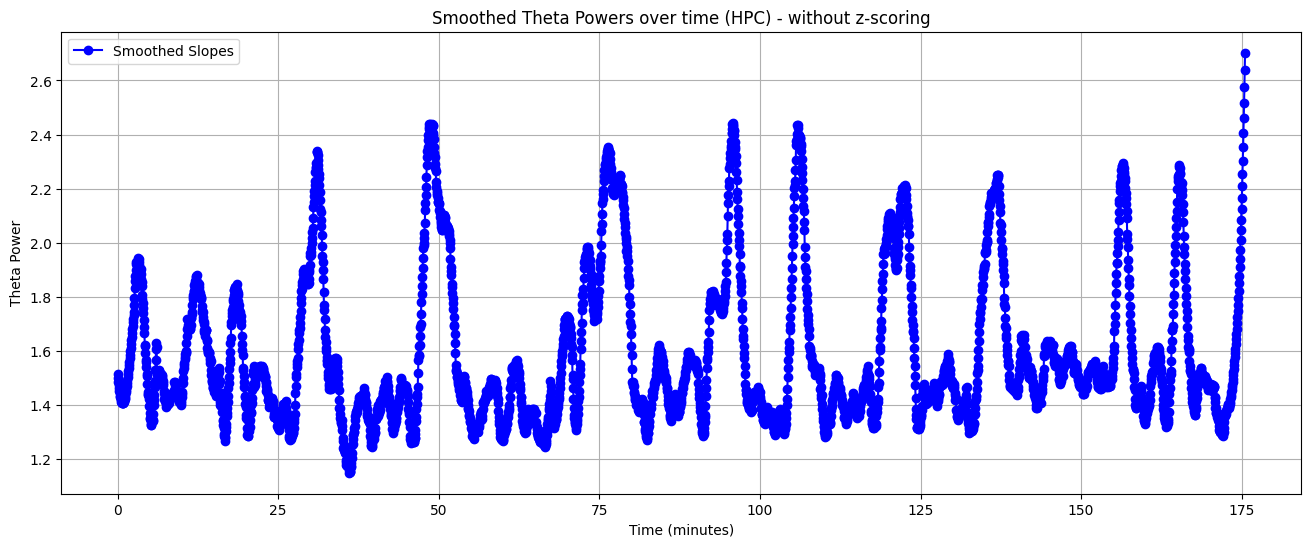

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time_minutes, theta_peak_smoothed_HPC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Theta Powers over time (HPC) - without z-scoring")
plt.xlabel("Time (minutes)")
plt.ylabel("Theta Power")
plt.grid(True)
plt.legend()
plt.show()

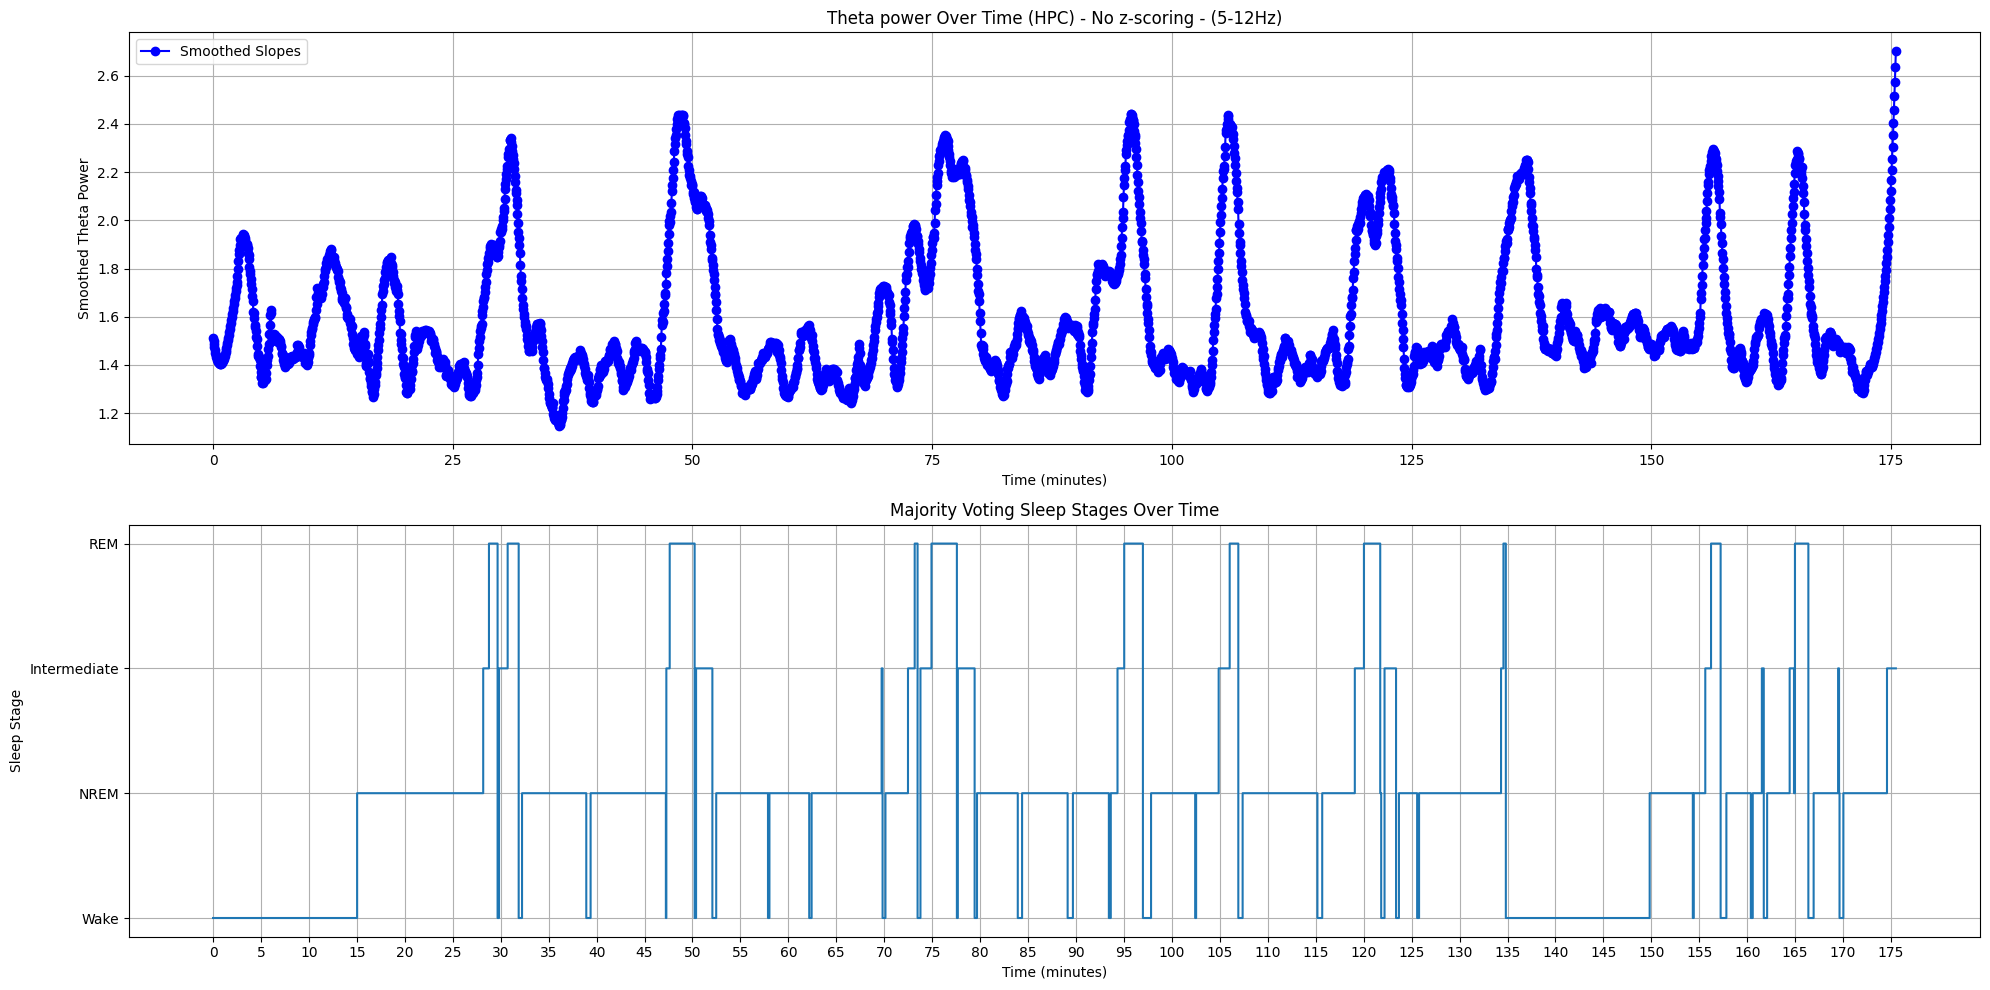

In [ ]:
score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}

sleep_scoring_ = sleep_scoring[:10533]
reshaped_scores = sleep_scoring_.reshape(-1, 3)
majority_scores = mode(reshaped_scores, axis=1).mode.flatten()

assert all(score in score_labels for score in majority_scores), "Some scores are not in score_labels"

mapped_scores = np.array([num_labels[score_labels[score]] for score in majority_scores])

time_minutes = np.arange(0, len(theta_peak_smoothed_HPC)) * 3 / 60
sleep_time_minutes = np.arange(0, len(majority_scores)) * 3 / 60

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(time_minutes, theta_peak_smoothed_HPC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Theta power Over Time (HPC) - No z-scoring - (5-12Hz)")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Theta Power")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.step(sleep_time_minutes, mapped_scores, where='mid')
plt.xlabel('Time (minutes)')
plt.ylabel('Sleep Stage')
plt.title('Majority Voting Sleep Stages Over Time')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xticks(np.arange(0, max(sleep_time_minutes) + 1, 5))
plt.grid(True)

plt.tight_layout()

plt.show()

In [ ]:
theta_peak_smoothed_HPC = np.asarray(theta_peak_smoothed_HPC)

means_smoothed = []
stds_smoothed = []
means_unsmoothed = []
stds_unsmoothed = []

score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
for score, label in score_labels.items():
    relevant_indices = majority_scores == score

    relevant_slopes_smoothed = theta_peak_smoothed_HPC[relevant_indices]
    means_smoothed.append(np.nanmean(relevant_slopes_smoothed))
    stds_smoothed.append(np.nanstd(relevant_slopes_smoothed))

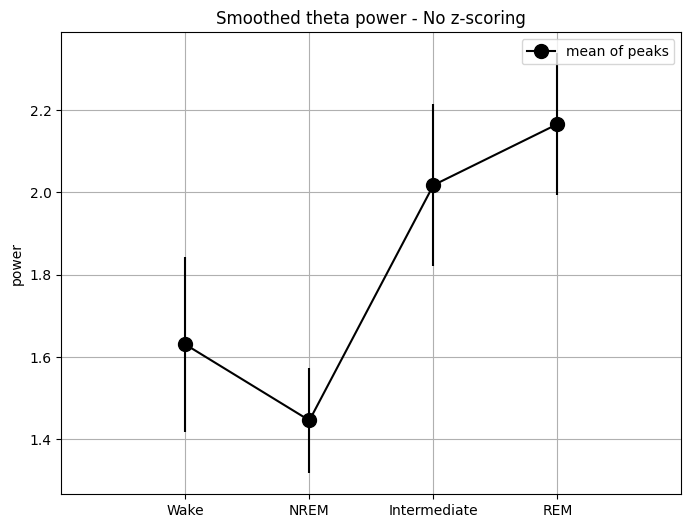

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(1, len(score_labels)+1), means_smoothed, yerr=stds_smoothed, fmt='-ok', markersize=10,
             markeredgecolor='black', markerfacecolor='black', label='mean of peaks')
plt.ylabel("power")
plt.title("Smoothed theta power - No z-scoring")
plt.grid(True)
plt.xticks(ticks=range(1, len(score_labels)+1), labels=score_labels.values())
plt.xlim(0, len(score_labels) + 1)
plt.legend()
plt.show()

#  Lempel-Ziv complexity


In [ ]:
def lzw(input_sequence):
    if set(input_sequence) - {0, 1}:
        raise ValueError('Input must be a list containing 0s and/or 1s only.')

    dictionary = {'0': True, '1': True}

    s = 0
    e = 1
    subsequence = str(input_sequence[s])

    while e < len(input_sequence):
        subsequence += str(input_sequence[e])
        if subsequence not in dictionary:
            dictionary[subsequence] = True
            s = e
            subsequence = str(input_sequence[s])
        e += 1

    complexity = len(dictionary)
    return complexity, dictionary

In [ ]:
def convert_string_to_binary_list(binary_string):
    return [int(char) for char in binary_string]

In [ ]:
def encode_signal_to_binary(window):
    median_value = np.median(window)
    return [1 if point > median_value else 0 for point in window]

window_size = 3
fs = 1000
window_length = window_size * fs

lz_complexity_values = []

for start in range(0, len(sig_hpc) - window_length + 1, window_length):
    window = sig_hpc[start:start + window_length]

    binary_sequence = encode_signal_to_binary(window)

    lz_complexity, _ = lzw(binary_sequence)

    lz_complexity_values.append(lz_complexity)

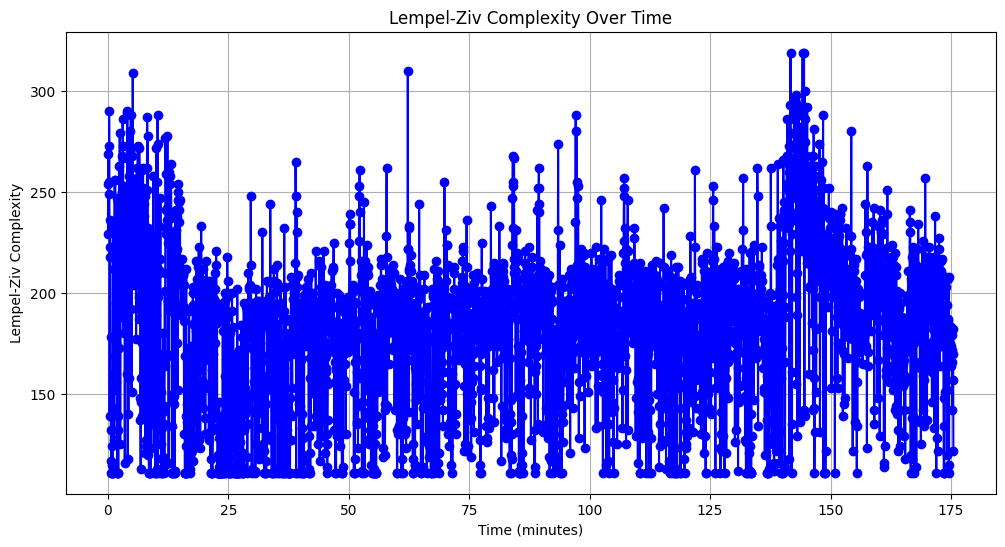

In [ ]:
time_array = np.arange(0, len(lz_complexity_values) * 3, 3) / 60  # Time in minutes

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_array, lz_complexity_values, marker='o', linestyle='-', color='blue')
plt.title("Lempel-Ziv Complexity Over Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Lempel-Ziv Complexity")
plt.grid(True)
plt.show()

In [ ]:
lzw_normalized_HPC = zscore(lz_complexity_values)
lzw_smoothed_HPC = savgol_filter(lzw_normalized_HPC, window_length=101, polyorder=4)

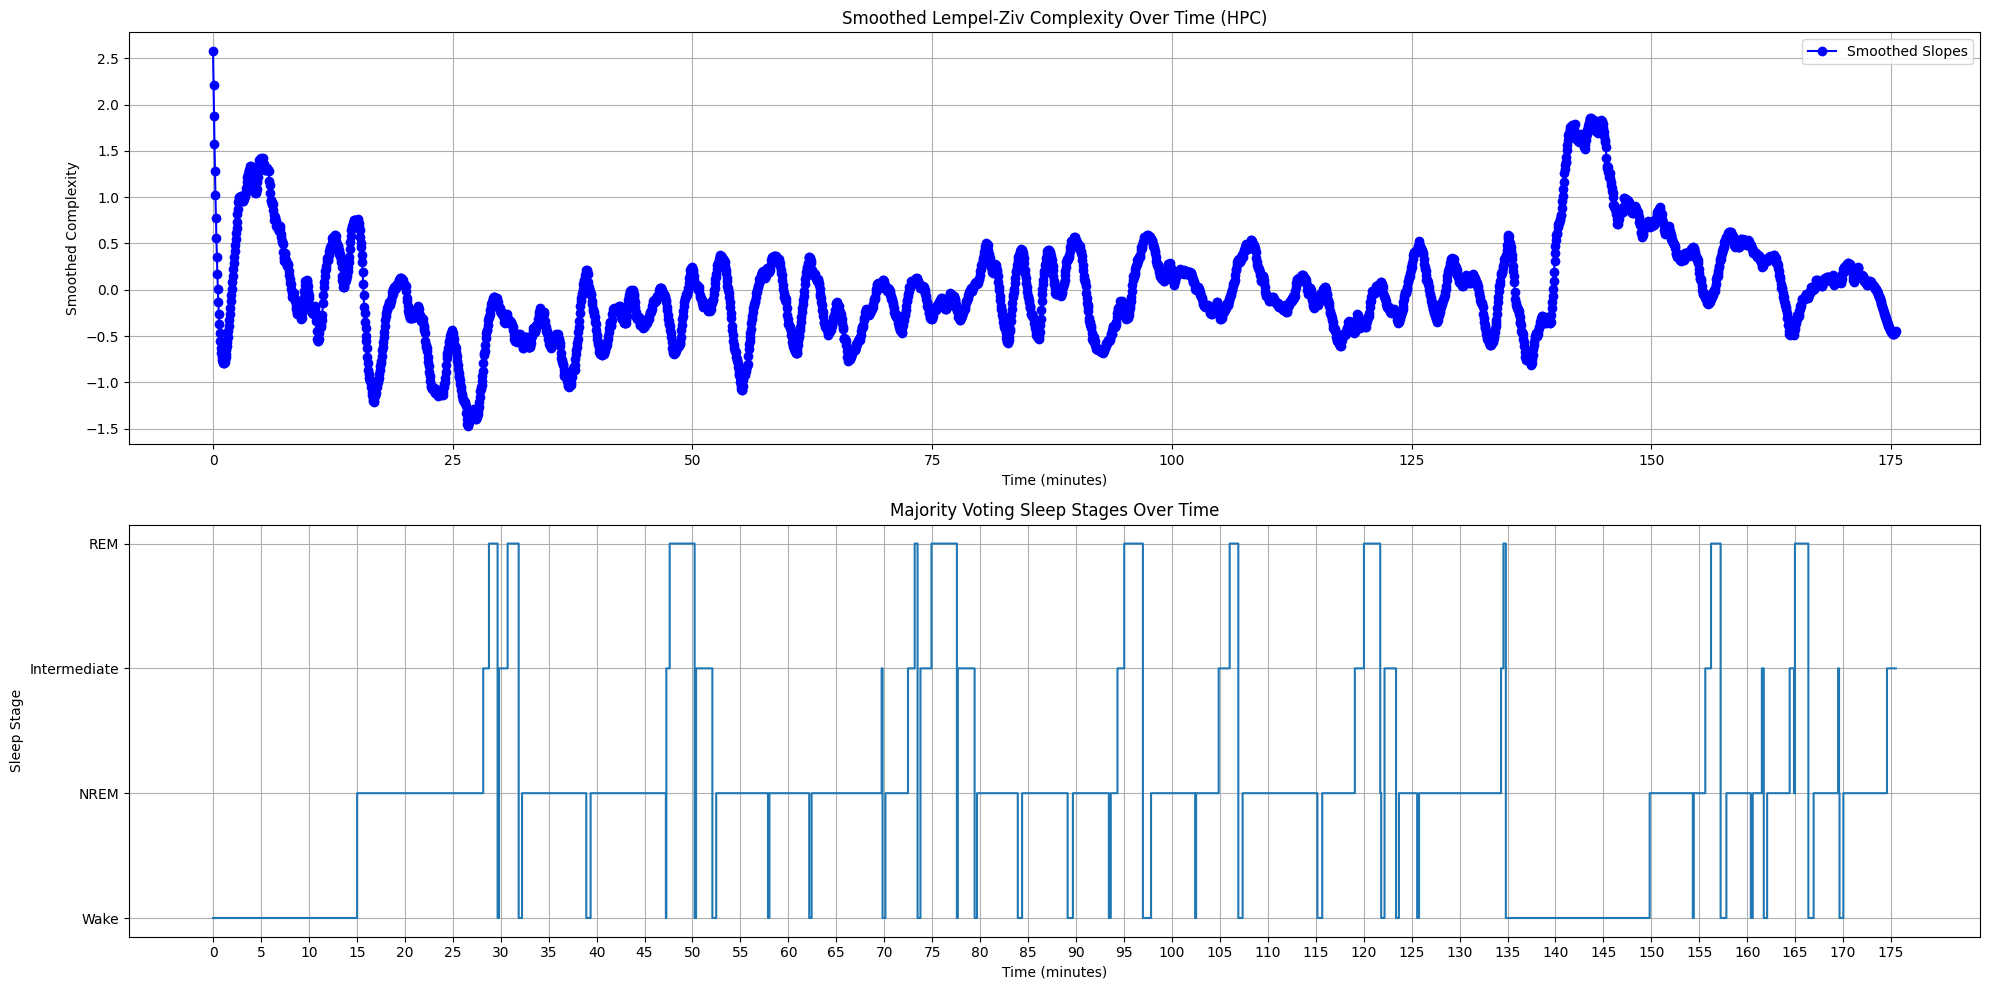

In [ ]:
score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}


mapped_scores = np.array([num_labels[score_labels[score]] for score in majority_scores])


time_minutes = np.arange(0, len(lzw_smoothed_HPC)) * 3 / 60
sleep_time_minutes = np.arange(0, len(majority_scores)) * 3 / 60

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(time_minutes, lzw_smoothed_HPC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Lempel-Ziv Complexity Over Time (HPC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Complexity")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.step(sleep_time_minutes, mapped_scores, where='mid')
plt.xlabel('Time (minutes)')
plt.ylabel('Sleep Stage')
plt.title('Majority Voting Sleep Stages Over Time')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xticks(np.arange(0, max(sleep_time_minutes) + 1, 5))
plt.grid(True)

plt.tight_layout()

plt.show()


In [ ]:
lzw_smoothed_HPC = np.asarray(lzw_smoothed_HPC)

means_smoothed = []
stds_smoothed = []
means_unsmoothed = []
stds_unsmoothed = []

score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
for score, label in score_labels.items():

    relevant_indices = majority_scores == score

    relevant_slopes_smoothed = lzw_smoothed_HPC[relevant_indices]
    means_smoothed.append(np.nanmean(relevant_slopes_smoothed))
    stds_smoothed.append(np.nanstd(relevant_slopes_smoothed))

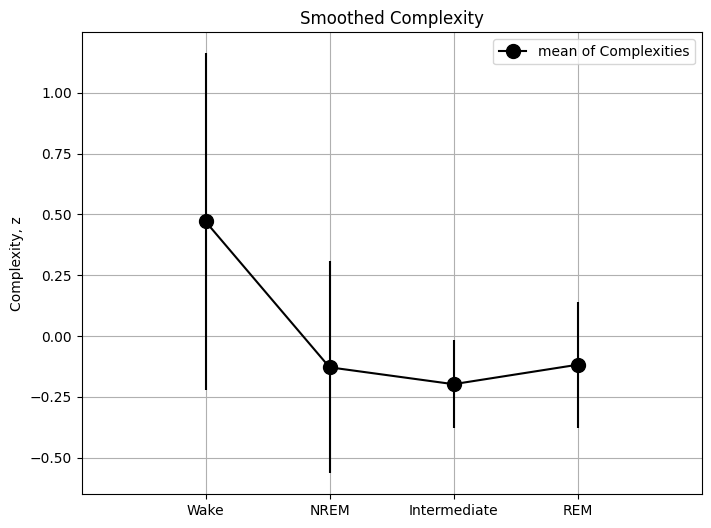

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(1, len(score_labels)+1), means_smoothed, yerr=stds_smoothed, fmt='-ok', markersize=10,
             markeredgecolor='black', markerfacecolor='black', label='mean of Complexities')
plt.ylabel("Complexity, z")
plt.title("Smoothed Complexity")
plt.grid(True)
plt.xticks(ticks=range(1, len(score_labels)+1), labels=score_labels.values())
plt.xlim(0, len(score_labels) + 1)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import random

def lzw_normalised(input_sequence, nr_shuffles):
    if nr_shuffles < 0:
        raise ValueError('nr_shuffles must be greater or equal to 0.')

    complexity_orig, _ = lzw(input_sequence)

    if nr_shuffles > 0:
        complexities_shuffled = []
        for _ in range(nr_shuffles):
            input_shuffled = input_sequence[:]
            random.shuffle(input_shuffled)
            complexity_shuffled, _ = lzw(input_shuffled)
            complexities_shuffled.append(complexity_shuffled)

        complexity_normalised = complexity_orig / np.mean(complexities_shuffled)
    else:
        complexity_normalised = complexity_orig

    return complexity_normalised

## LZW Normalized


In [ ]:
def encode_signal_to_binary(window):
    median_value = np.median(window)
    return [1 if point > median_value else 0 for point in window]

window_size = 3
fs = 1000
window_length = window_size * fs

lz_complexity_values = []

for start in range(0, len(sig_hpc) - window_length + 1, window_length):
    window = sig_hpc[start:start + window_length]

    binary_sequence = encode_signal_to_binary(window)

    lz_complexity = lzw_normalised(binary_sequence, 10)

    lz_complexity_values.append(lz_complexity)

In [ ]:
lzw_normalized_HPC = zscore(lz_complexity_values)
lzw_smoothed_HPC = savgol_filter(lzw_normalized_HPC, window_length=101, polyorder=4)

In [ ]:
lzw_smoothed_HPC = np.asarray(lzw_smoothed_HPC)

means_smoothed = []
stds_smoothed = []
means_unsmoothed = []
stds_unsmoothed = []

score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
for score, label in score_labels.items():
    relevant_indices = majority_scores == score

    relevant_slopes_smoothed = lzw_smoothed_HPC[relevant_indices]
    means_smoothed.append(np.nanmean(relevant_slopes_smoothed))
    stds_smoothed.append(np.nanstd(relevant_slopes_smoothed))

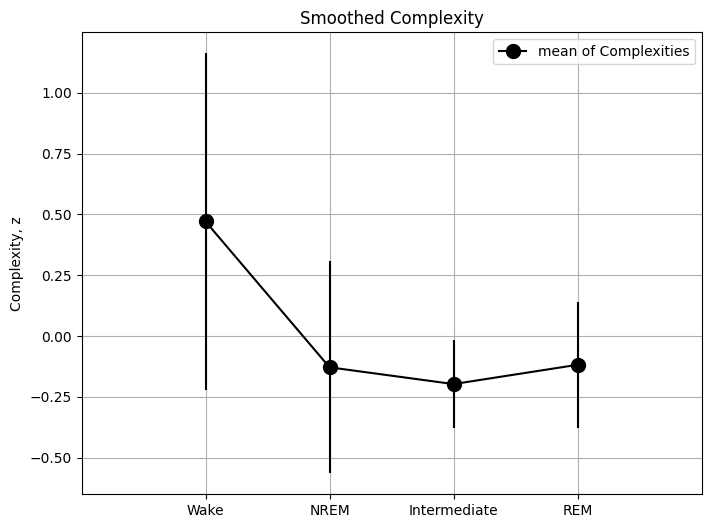

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(1, len(score_labels)+1), means_smoothed, yerr=stds_smoothed, fmt='-ok', markersize=10,
             markeredgecolor='black', markerfacecolor='black', label='mean of Complexities')
plt.ylabel("Complexity, z")
plt.title("Smoothed Complexity")
plt.grid(True)
plt.xticks(ticks=range(1, len(score_labels)+1), labels=score_labels.values())
plt.xlim(0, len(score_labels) + 1)
plt.legend()
plt.show()

# EMG

In [ ]:
file_path = path_to_pt5 + '/rgs14.npz'
loaded_data = np.load(file_path)

In [ ]:
mat = loaded_data['d']

In [ ]:
mat = np.array(mat)

In [ ]:
mat = mat[7:]

In [ ]:
mat.shape

(10535, 4)

In [ ]:
emg_mat = mat[:, -1]

In [ ]:
reshaped_data = emg_mat[:len(emg_mat) // 3 * 3].reshape(-1, 3)

summed_emg = reshaped_data.sum(axis=1)
normalized_summed_emg = zscore(summed_emg)

In [ ]:
features_matrix = np.stack((theta_power_array, delta_power_array, normalized_ratio, slopes_normalized_HPC, lzw_normalized_HPC, normalized_summed_emg), axis=-1)


In [ ]:
features_matrix.shape

(3511, 6)

In [ ]:
np.save('features_matrix.npy', features_matrix)

In [ ]:
slopes_smoothed_HPC

In [ ]:
features_matrix_smoothed = np.stack((theta_power_array, delta_power_array, normalized_ratio, slopes_smoothed_HPC, lzw_normalized_HPC, normalized_summed_emg), axis=-1)


In [ ]:
np.save('features_matrix_smoothed.npy', features_matrix_smoothed)

# Correlation

In [ ]:
theta_band = [5, 12]
freq_range = [1, 100]

def extract_highest_theta_peak(lfp_data, fs, theta_band, freq_range):
    highest_theta_peak_params = []
    window_length = 3 * fs

    for start in range(0, len(lfp_data) - window_length + 1, window_length):
        window = lfp_data[start:start + window_length]
        freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)

        fm = FOOOF()
        fm.fit(freq_mean, psd_mean, freq_range)

        highest_peak = None
        for peak in fm.peak_params_:
            center_freq, peak_power, bandwidth = peak
            if theta_band[0] <= center_freq <= theta_band[1]:
                if highest_peak is None or peak_power > highest_peak[1]:
                    highest_peak = (center_freq, peak_power, bandwidth)

        if highest_peak:
            highest_theta_peak_params.append(highest_peak[1])
        else:
            highest_theta_peak_params.append(np.mean(highest_theta_peak_params[-1] + highest_theta_peak_params[-2]))

    return highest_theta_peak_params

In [ ]:
highest_theta_peaks = extract_highest_theta_peak(sig_hpc_nclean, fs, theta_band, freq_range)

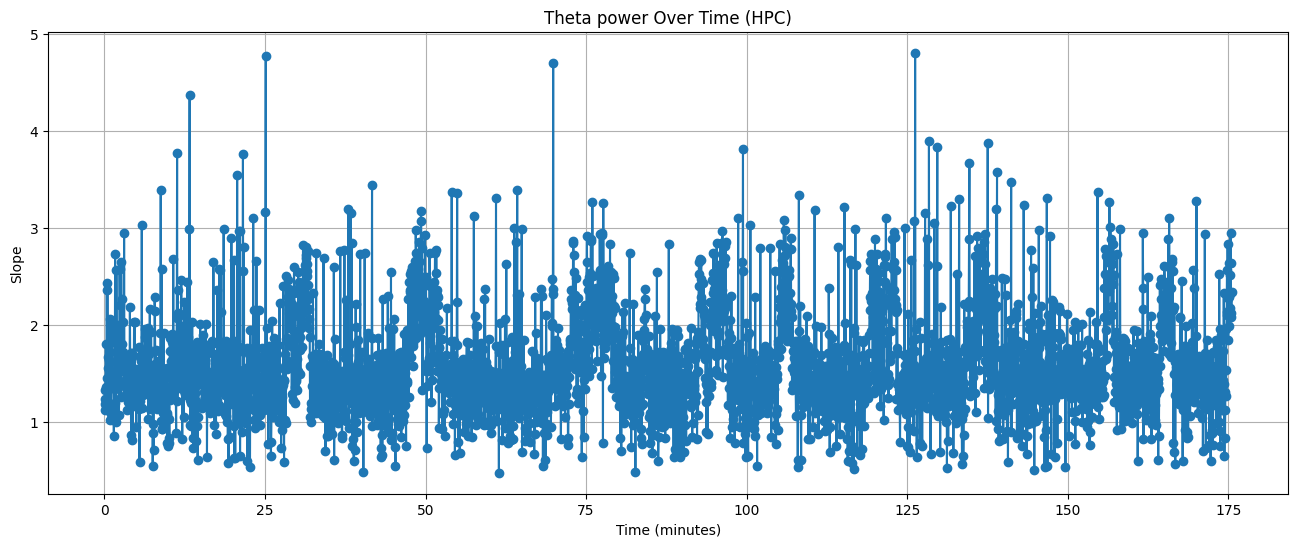

In [ ]:
time = np.arange(1.5, 1.5 + 3 * len(highest_theta_peaks), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, highest_theta_peaks, marker='o', linestyle='-')
plt.title("Theta power Over Time (HPC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()

In [ ]:
# Normalizing and smoothing the data
theta_peak_normalized_HPC_zscore = zscore(highest_theta_peaks)
theta_peak_smoothed_HPC_zscore = savgol_filter(theta_peak_normalized_HPC_zscore, window_length=101, polyorder=4)

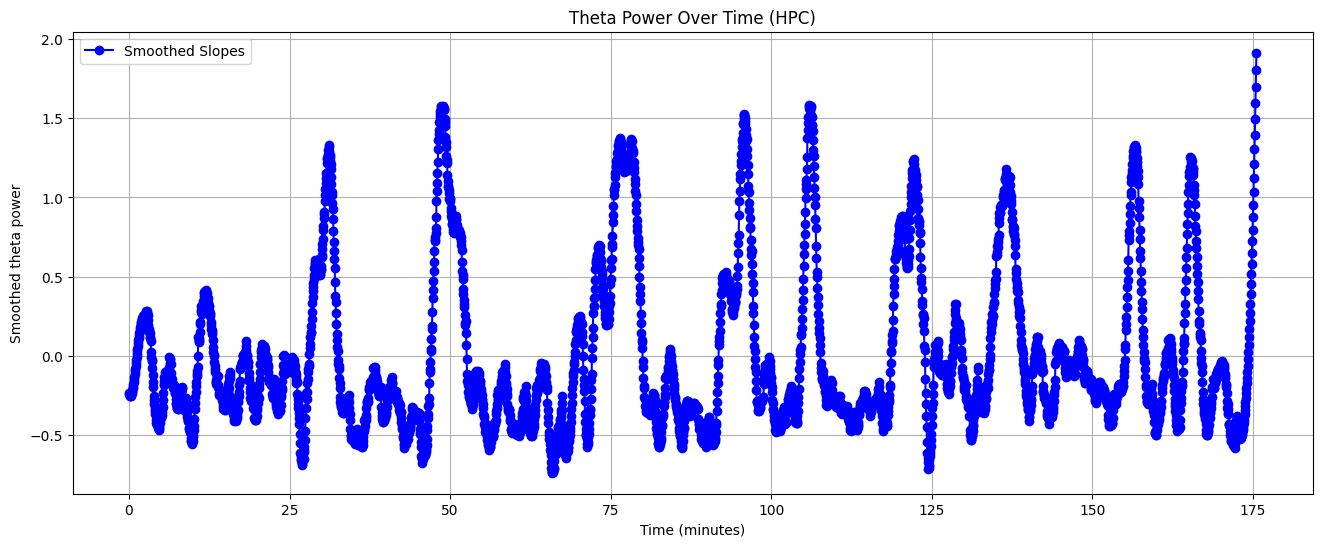

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time_minutes, theta_peak_smoothed_HPC_zscore, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Theta Power Over Time (HPC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed theta power")
plt.grid(True)
plt.legend()
plt.show()

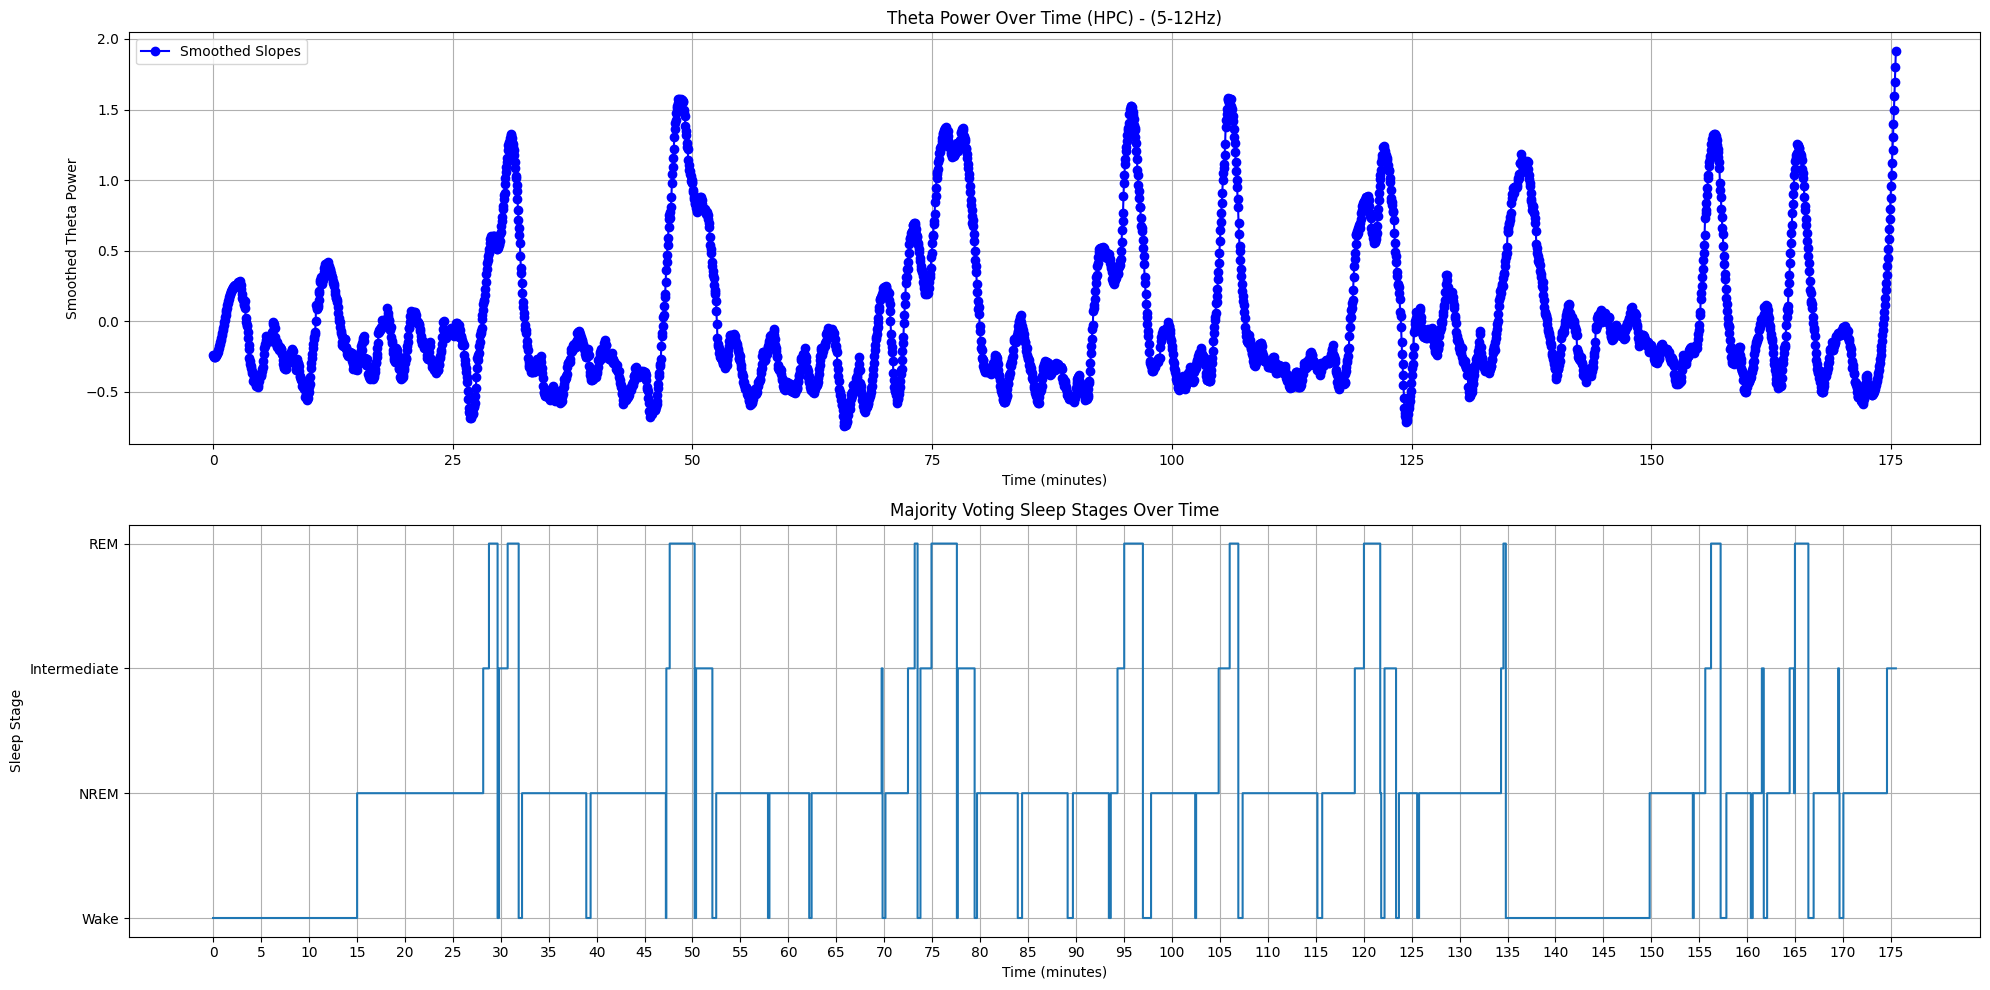

In [ ]:
score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}

mapped_scores = np.array([num_labels[score_labels[score]] for score in majority_scores])

time_minutes = np.arange(0, len(theta_peak_smoothed_HPC_zscore)) * 3 / 60
sleep_time_minutes = np.arange(0, len(majority_scores)) * 3 / 60

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(time_minutes, theta_peak_smoothed_HPC_zscore, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Theta Power Over Time (HPC) - (5-12Hz)")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Theta Power")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.step(sleep_time_minutes, mapped_scores, where='mid')
plt.xlabel('Time (minutes)')
plt.ylabel('Sleep Stage')
plt.title('Majority Voting Sleep Stages Over Time')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xticks(np.arange(0, max(sleep_time_minutes) + 1, 5))
plt.grid(True)

plt.tight_layout()

plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.DataFrame({
    'normalized_delta_power': normalized_delta_power,
    'theta_peak_normalized_HPC_zscore': theta_peak_normalized_HPC_zscore,
    'slopes_smoothed_HPC': slopes_smoothed_HPC
})

correlation_matrix = df.corr()
print(correlation_matrix)


                                  normalized_delta_power  \
normalized_delta_power                          1.000000   
theta_peak_normalized_HPC_zscore               -0.056866   
slopes_smoothed_HPC                             0.160682   

                                  theta_peak_normalized_HPC_zscore  \
normalized_delta_power                                   -0.056866   
theta_peak_normalized_HPC_zscore                          1.000000   
slopes_smoothed_HPC                                      -0.354004   

                                  slopes_smoothed_HPC  
normalized_delta_power                       0.160682  
theta_peak_normalized_HPC_zscore            -0.354004  
slopes_smoothed_HPC                          1.000000  


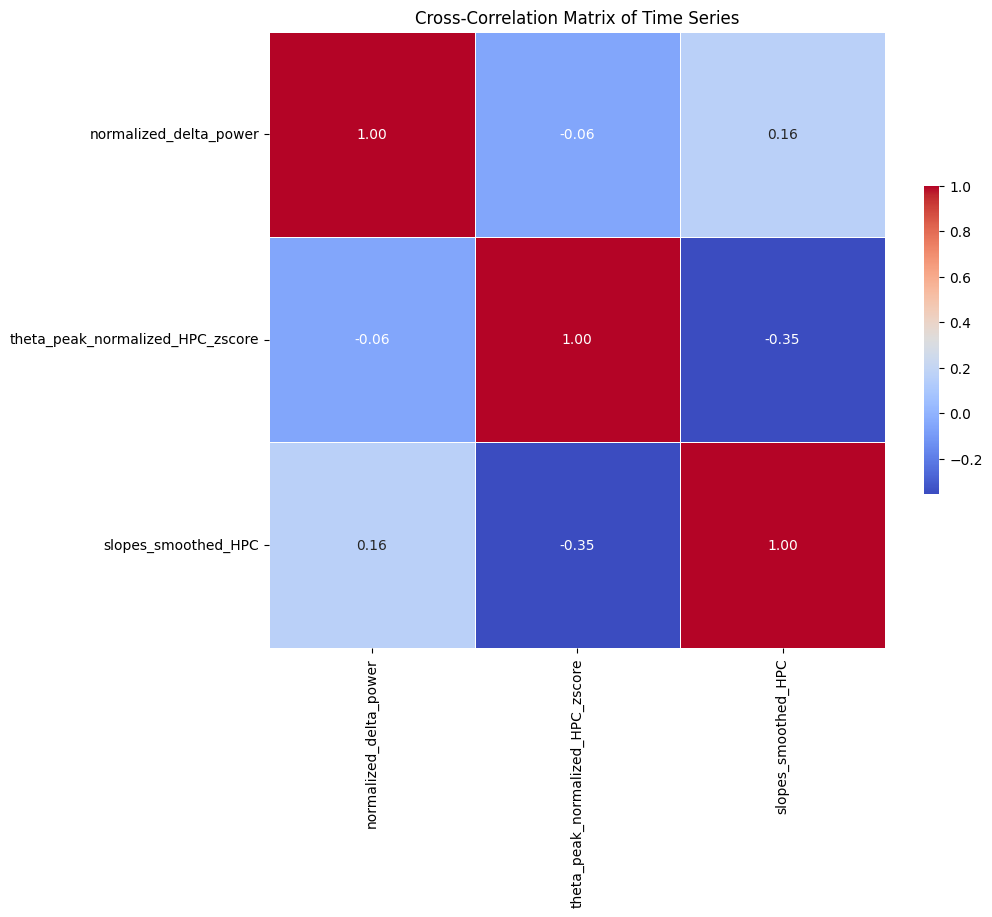

In [ ]:
cross_correlation_matrix = df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(cross_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Cross-Correlation Matrix of Time Series')
plt.show()

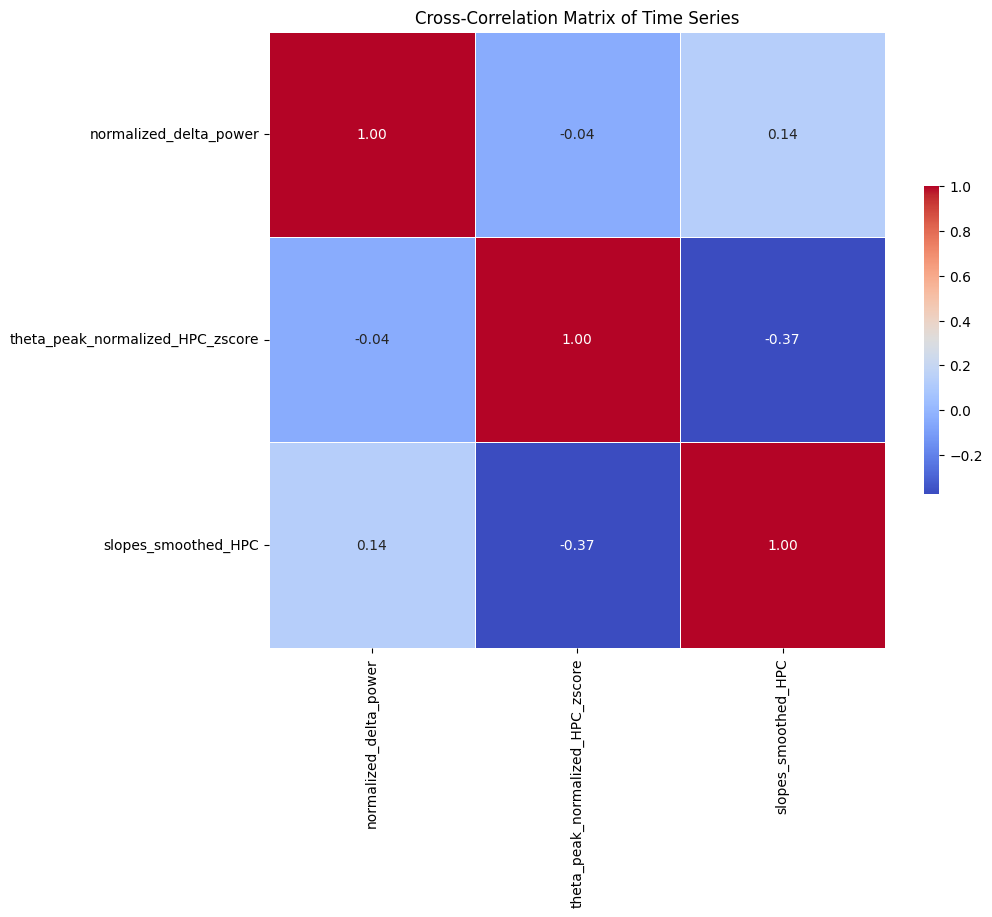

In [ ]:
cross_correlation_matrix = df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(cross_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Cross-Correlation Matrix of Time Series')
plt.show()

<Figure size 1400x800 with 0 Axes>

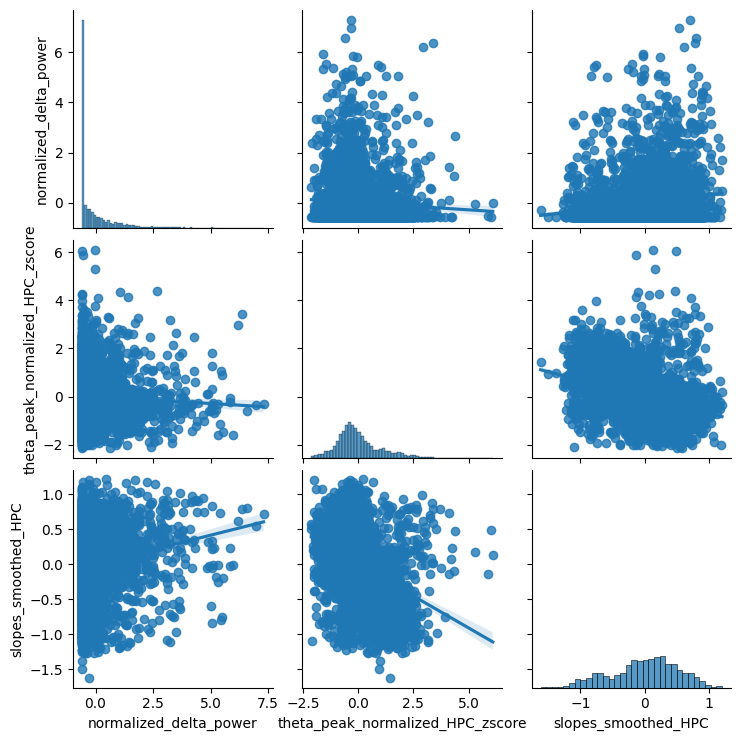

In [ ]:
plt.figure(figsize=(14,8))
sns.pairplot(df[['normalized_delta_power','theta_peak_normalized_HPC_zscore','slopes_smoothed_HPC']], kind="reg")

In [ ]:
import numpy as np
from scipy.signal import correlate


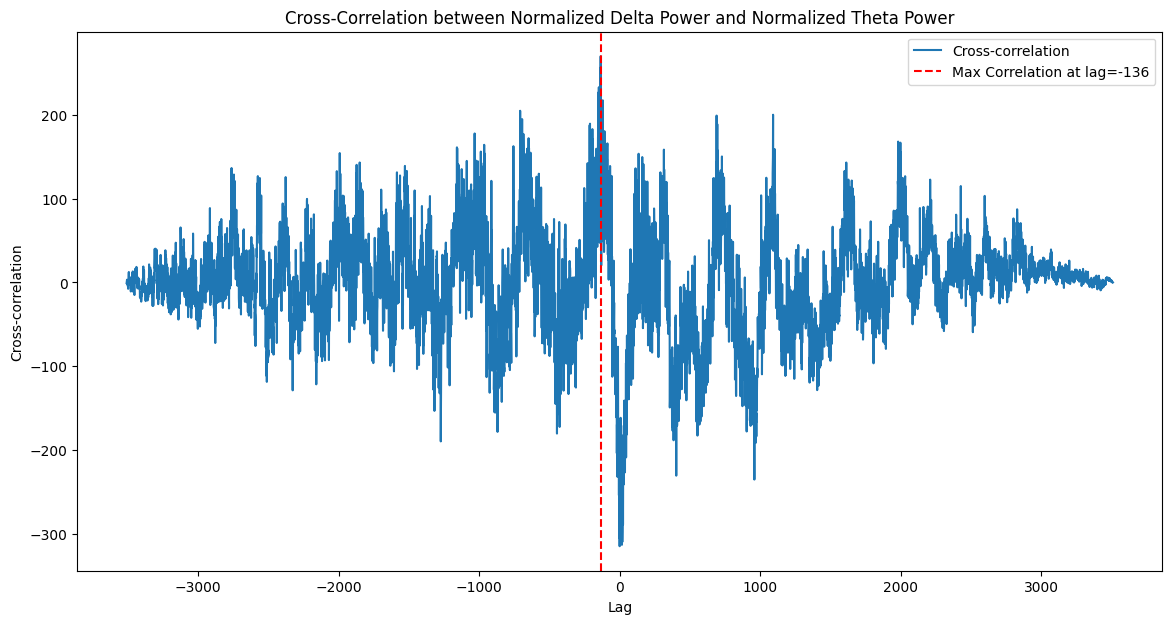

(-136, 270.2066672741656)

In [ ]:
cross_correlation = np.correlate(normalized_delta_power, normalized_theta_power, mode='full')

lags = np.arange(-(len(normalized_delta_power)-1), len(normalized_theta_power))

max_lag = lags[np.argmax(cross_correlation)]

plt.figure(figsize=(14, 7))
plt.plot(lags, cross_correlation, label='Cross-correlation')
plt.axvline(max_lag, color='red', linestyle='--', label=f'Max Correlation at lag={max_lag}')
plt.title('Cross-Correlation between Normalized Delta Power and Normalized Theta Power')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.legend()
plt.show()

max_lag, np.max(cross_correlation)